<a href="https://colab.research.google.com/github/debasmi/eqtolatex-qwen/blob/main/matheqlaTex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 13.1 MB/s eta 0:00:00


In [6]:
from unsloth import FastVisionModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [7]:
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit"
]

In [8]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [9]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state = 3407,
    use_rslora=False,
    loftq_config=None
)

Unsloth: Making `model.base_model.model.visual` require gradients


In [10]:
from datasets import load_dataset
dataset = load_dataset("unsloth/Latex_OCR", split="train")

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [11]:
dataset


Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [12]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>,
 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}

In [16]:
instruction = "Write the LaTex representation for this image."

In [17]:
def convert_to_conversation(sample):
  conversation = [
      {"role": "user",
       "content": [
           {"type": "text", "text": instruction},
           {"type": "image", "image": sample["image"]}
       ]
       },
      {"role": "assistant",
       "content": [
           {"type": "text", "text": sample["text"]}
       ]
       }
  ]
  return {"messages": conversation}


In [18]:
convert_to_conversation(dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

In [19]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [20]:
converted_dataset[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation for this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,'}]}]}

In [21]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (visual): Qwen2VisionTransformerPretrainedModel(
        (patch_embed): PatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-18): 19 x Qwen2VLVisionBlock(
            (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (attn): VisionSdpaAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(


In [22]:
image = dataset[1]["image"]
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": instruction},
            {"type": "image", "image": image}
        ]
    }
]

In [23]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

In [24]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer= text_streamer, max_new_tokens = 128, use_cache=True, temperature=1.5, min_p=0.1)

The LaTeX representation for the image is:

```latex
D^{\mu}_{\mu} \tilde{A}^{\mu}_{\mu} = 0,
```<|im_end|>


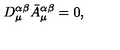

In [25]:
image


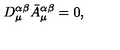

In [26]:
dataset[1]["image"]

In [27]:
dataset[1]["text"]

'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,'

In [31]:
#not matching therefore we will finetune hence model doesnt have the feature

In [29]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [32]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (visual): Qwen2VisionTransformerPretrainedModel(
        (patch_embed): PatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-18): 19 x Qwen2VLVisionBlock(
            (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (attn): VisionSdpaAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(


In [41]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model,tokenizer),
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size=2,#vision model requires memory so keeping it 2 to be trained at a time
        gradient_accumulation_steps=4,#updating wights batch size becomes : 2*4
        warmup_steps=5,#learning rate increases reduces starting instability
        max_steps=30,#training to 30 update steps for demo:product uses epoch based tarining or max steps
        learning_rate=2e-4,#typical for lora adaptionor 10^-4
        fp16=not is_bf16_supported(),#better
        bf16=is_bf16_supported(),
        optim="adamw_8bit",#8 bit optimizer reduces optmizer state memory by 75% compared to the full precision
        logging_steps=1,#trading a bit of memory for maximum memory benefit/efficiency
        weight_decay=0.01,#penalizes large wts to imporve generalization (no skew to one end based on a certain parameter correct distribution-overfitting)
        lr_scheduler_type="linear",#after warm up learning rate reduces to 0 linearly
        seed=3407,#peak seed ensures consistent result across runs and minimal reporting
        output_dir="outputs",
        report_to="none",
        remove_unused_columns=False,#preserves image data based on features during batch prep so imp for vision models
        dataset_text_field="",#dataset already formatted correctly
        dataset_kwargs={"skip_prepare_dataset":True},
        dataset_num_proc=4,#parallel workers for data processing
        max_seq_length=2048,#accomodates tokens includes input and generated output
    ),
)

Unsloth: Model does not have a default image size - using 512


In [42]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936/7,000,000,000 (0.73% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.184900
2,1.332900
3,1.426800
4,0.990700
5,0.902100
6,0.891200
7,0.706300
8,0.467100
9,0.291900
10,0.323400


TrainOutput(global_step=30, training_loss=0.3921132040520509, metrics={'train_runtime': 313.405, 'train_samples_per_second': 0.766, 'train_steps_per_second': 0.096, 'total_flos': 1673161698422784.0, 'train_loss': 0.3921132040520509})

In [43]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (visual): Qwen2VisionTransformerPretrainedModel(
        (patch_embed): PatchEmbed(
          (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
        (rotary_pos_emb): VisionRotaryEmbedding()
        (blocks): ModuleList(
          (0-18): 19 x Qwen2VLVisionBlock(
            (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
            (attn): VisionSdpaAttention(
              (qkv): lora.Linear(
                (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1280, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(


In [44]:
image = dataset[2]["image"]

In [45]:
instruction = "write the latex representation for this image"

In [46]:
messages = [
    {"role":"user","content":[
      {"type":"image"},
      {"type":"text",
        "text":instruction
    }]}
]

In [47]:
input_text=tokenizer.apply_chat_template(messages,add_generation_prompt=True)
inputs = tokenizer(
    image,input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to("cuda")

In [48]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer,skip_prompt=True)
_ = model.generate(**inputs,streamer=text_streamer,max_new_tokens=128,use_cache=True,temperature=1.5,min_p=0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \zeta ^ { \dagger } \partial _ { \lambda } \zeta + V ( \lambda ) \zeta ^ { \dagger } \zeta \right\} \ .<|im_end|>


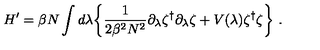

In [49]:
image